<a href="https://colab.research.google.com/github/andy311p/Udemy_advanced_NLP/blob/master/NLP_LSTM_toxic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installations
!pip install kaggle
!cp drive/My\ Drive/nlp_course/kaggle.json /root/.kaggle/
!git clone https://github.com/lazyprogrammer/machine_learning_examples.git

In [ ]:
#Imports and HyperParameters
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, GlobalMaxPool1D  
from keras.layers import LSTM, Bidirectional, Dropout #changes
from keras.optimizers import Adam #changes
from keras.models import Model
from sklearn.metrics import roc_auc_score

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
#load word vectors
print("Loading word vectors START")
word2vec = {}
with open(os.path.join('drive/My Drive/nlp_course/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  for line in f:
    line = line.split()
    word2vec[line[0]] = np.asarray(line[1:],dtype='float32')
print("Loaded %s word vectors" % len(word2vec))


Loading word vectors START
Loaded 400000 word vectors


In [ ]:
#Load training data
print("Loading training data START")
train = pd.read_csv("drive/My Drive/nlp_course/train.csv")

#.values converts the result from pandas to numpy array
sentences = train['comment_text'].values
possible_labels = train.columns[2:].values
targets = train[possible_labels].values
#print("max length: ", max(len(s) for s in sentences))

Loading training data START


In [ ]:
#Pre process data
#create a tokenizer for the texts and convert them into numbers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences) #tokenized sentences
data = pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH) #padded tokenized sentences

#get the word->index dictionary
word2idx = tokenizer.word_index

# print(sequences[0])
# print(data[0])

In [ ]:
#Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1) #the actual size of vocabulary. +1 for padding
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for w,i in word2idx.items():
  if i< MAX_VOCAB_SIZE:
    if w in word2vec:
      embedding_matrix[i] = word2vec[w]

In [ ]:
#Embedding layer
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

#model architecture
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15,return_sequences=True)(x)
#x = Bidirectional(LSTM(15,return_sequences=True))(x) #this is how you turn an LSTM into a biderectional LSTM
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels),activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.01),
    metrics=['accuracy']
)

In [ ]:
print("Training time.....")
res = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Training time.....
Epoch 1/10
998/998 [==============================] - 54s 54ms/step - loss: 0.0851 - accuracy: 0.9918 - val_loss: 0.0618 - val_accuracy: 0.9940
Epoch 2/10
998/998 [==============================] - 55s 55ms/step - loss: 0.0577 - accuracy: 0.9920 - val_loss: 0.0578 - val_accuracy: 0.9913
Epoch 3/10
998/998 [==============================] - 55s 55ms/step - loss: 0.0541 - accuracy: 0.9886 - val_loss: 0.0547 - val_accuracy: 0.9863
Epoch 4/10
998/998 [==============================] - 55s 55ms/step - loss: 0.0514 - accuracy: 0.9882 - val_loss: 0.0539 - val_accuracy: 0.9882
Epoch 5/10
998/998 [==============================] - 56s 56ms/step - loss: 0.0502 - accuracy: 0.9864 - val_loss: 0.0539 - val_accuracy: 0.9888
Epoch 6/10
998/998 [==============================] - 55s 55ms/step - loss: 0.0492 - accuracy: 0.9817 - val_loss: 0.0535 - val_accuracy: 0.9938
Epoch 7/10
998/998 [==============================] - 55s 55ms/step - loss: 0.0484 - accuracy: 0.9859 - val_loss: 0.0

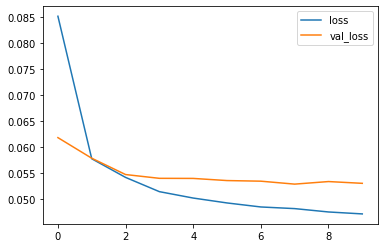

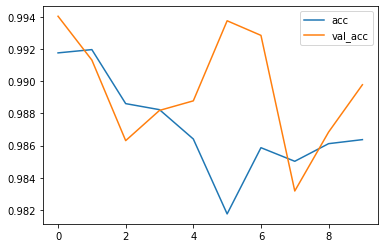

0.982049655214306


In [ ]:
# plot some data
plt.plot(res.history['loss'], label='loss')
plt.plot(res.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(res.history['accuracy'], label='acc')
plt.plot(res.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

[[[-0.5801525   0.06808588 -0.04721453]
  [ 0.32034228 -0.62727557 -2.44219065]
  [ 0.23404343  1.38661925  0.07614053]]

 [[ 0.83267963  0.19208428  1.02801091]
  [-0.88827598 -1.47248712 -0.57494242]
  [ 0.11928063 -0.08006667 -2.4718639 ]]

 [[-0.04368834 -0.26788151  0.65371636]
  [ 1.62533369  0.80078791  0.06781377]
  [ 1.03668321  0.50337205 -1.04663385]]]
